In [3]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt

%matplotlib inline

In [4]:
def import_gpd(filename):
    data = pd.read_csv(filename)
    data['geometry'] = data['geometry'].apply(wkt.loads)
    data_gpd = gpd.GeoDataFrame(data, geometry = data['geometry'], crs={'init' :'epsg:4326'})
    data_gpd = data_gpd.drop(['Unnamed: 0'], axis = 1)
    return(data_gpd)

def distance_to_zoning(gps, zone):
    dists = []
    for i in zone.geometry:
        dists.append(i.distance(gps))
    return(np.min(dists))

# Zoning import and cleaning

In [5]:
## import zoning data
oak_zones = gpd.read_file('Zoning/geo_export_71821546-6249-4fba-96d0-1790317fdc6c.shp')
np.sum(oak_zones.geometry.notnull() == False)

10

In [6]:
# drop extraneous columns
extra_cols = ['overlay', 'date_expir', 'time_expir', 'area', 'znlabel', 'date_updat', 'time_updat', 'date_effct',
              'time_effct']

oak_zones = oak_zones.drop(extra_cols, axis = 1)
oak_zones.head()

,perimeter,basezone,ordinance,geometry
0,40159.850561,CIX-1,12875,"POLYGON ((-122.2822453419509 37.8202864225731,..."
1,8355.138459,CIX-1,12875,POLYGON ((-122.2812909540165 37.80236514210691...
2,29069.501825,CIX-1,12875,"POLYGON ((-122.292493335741 37.81916077866173,..."
3,1498.555904,OS (NP),None,POLYGON ((-122.1773177128875 37.72609018686309...
4,1532.053852,OS (NP),None,POLYGON ((-122.1895589114374 37.73089057106102...


In [7]:
## remove null polygons (causes issues with merges)
oak_zones.shape
oak_zones = oak_zones[oak_zones.geometry.notnull()]

In [8]:
oak_zones.basezone.unique()

array(['CIX-1', 'OS (NP)', 'RM-1', 'CIX-2', 'OS (AMP)', 'CN-4',
       'OS (RCA)', 'RM-3', 'RD-1', 'CN-3', 'RM-4', 'OS (CP)', 'M-40',
       'RD-2', 'CC-2', 'RM-2', 'CC-1', 'OS (SU)', 'RU-4', 'IG', 'RH-2',
       'S-15', 'CR-1', 'OS (AF)', 'RU-5', 'RU-3', 'RH-3', 'RU-2',
       'OS (LP)', 'CN-2', 'OS (PMP)', 'R-80', 'M-20', 'RH-4', 'C-45',
       'RH-1', 'S-1', 'CN-1', 'RU-1', 'C-40', 'M-30', 'CC-3', 'OS(LP)',
       'OS(NP)', 'OS (RSP)', 'OS(CP)', 'Wood Street', 'S-2', 'HBX-1',
       'D-KP-3', 'D-OTN', 'HBX-2', 'HBX-3', 'IO', 'CBD-P', 'CBD-X',
       'CBD-C', 'CBD-R', 'RU-3/D-BR', 'S-3', 'OS(PMP)', 'D-KP-1',
       'D-KP-2', 'K-DP-4'], dtype=object)

In [9]:
## Basic cleaning of zoning districts 
oak_zones['zone'] = oak_zones['basezone'].apply(lambda x: x.replace(' ', '-').split('-')[0])
oak_zones['zone'] = np.where(oak_zones['zone'].str.contains('OS'), 'open', oak_zones['zone'])
oak_zones['zone'] = np.where(oak_zones['zone'].str.contains('Wood'), 'RM', oak_zones['zone'])

In [10]:
print(oak_zones['zone'].unique())

['CIX' 'open' 'RM' 'CN' 'RD' 'M' 'CC' 'RU' 'IG' 'RH' 'S' 'CR' 'R' 'C'
 'HBX' 'D' 'IO' 'CBD' 'K']


In [11]:
## zoning designations that can (hopefully) be generalized across the Bay Area
residential = ['RM', 'RD', 'RU', 'RH', 'R']
commercial = ['CN', 'CC', 'S', 'CR', 'HBX', 'D', 'C', 'K']
urban = ['CBD']
industrial = ['CIX', 'IG', 'IO', 'M']

In [12]:
## simply down to the above zoning designations
oak_zones['zone'] = oak_zones['zone'].replace(dict.fromkeys(residential, 'residential'))
oak_zones['zone'] = oak_zones['zone'].replace(dict.fromkeys(commercial, 'commercial'))
oak_zones['zone'] = oak_zones['zone'].replace(dict.fromkeys(urban, 'urban'))
oak_zones['zone'] = oak_zones['zone'].replace(dict.fromkeys(industrial, 'industrial'))

print(oak_zones['zone'].unique())

['industrial' 'open' 'residential' 'commercial' 'urban']


In [13]:
# dissolve zones for easy iteration to points later
oak_zones = oak_zones.dissolve(by='zone', aggfunc='sum')
oak_zones = oak_zones.reset_index()

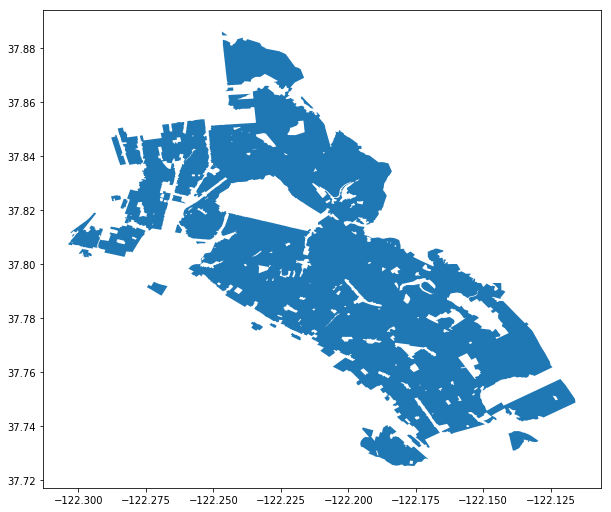

In [14]:
oak_zones[oak_zones['zone'] == 'residential'].plot(figsize=(10,10));

# Import Census data for population density

In [19]:
# Import Census data
CA_tracts = import_gpd('all_demographics.csv')

In [20]:
# drop extraneous columns and rename census variables
extra_cols = ['STATEFP', 'COUNTYFP', 'TRACTCE', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'NAME_y', 'NAMELSAD',
              'INTPTLAT', 'INTPTLON']

CA_tracts = CA_tracts.drop(extra_cols, axis=1)
CA_tracts = CA_tracts.rename(index=str, columns = {'B01003_001E': 'population', 'B01003_001M': 'pop_var',
                                                   'NAME_x': 'tract_name'})
CA_tracts.head(3)

,population,pop_var,tract_name,GEOID,state,county,tract,geometry
0,3353,332,"Census Tract 4001, Alameda County, California",6001400100,6,1,400100,"POLYGON ((-122.24692 37.885438, -122.246668 37..."
1,1944,147,"Census Tract 4002, Alameda County, California",6001400200,6,1,400200,"POLYGON ((-122.257923 37.842606, -122.257728 3..."
2,5376,539,"Census Tract 4003, Alameda County, California",6001400300,6,1,400300,"POLYGON ((-122.265631 37.837636, -122.265565 3..."


In [21]:
# calculate area and population density
CA_tracts['area'] = CA_tracts.to_crs({'init': 'epsg:32610'}).geometry.area / 1e6 #km2
CA_tracts['pop_den'] = CA_tracts['population'] / CA_tracts['area']

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


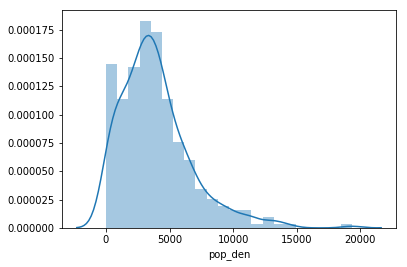

In [187]:
# population densities in Alameda county
Al_tracts = CA_tracts[CA_tracts.county == 1]
sns.distplot(Al_tracts.pop_den);

# Bring it all together with EDF dataset

In [260]:
GSV_df = import_gpd('EDF_output.csv')
GSV_df.shape

(18282, 13)

In [261]:
# left merge with the zoning data
GSV_all = gpd.sjoin(GSV_df, oak_zones, how='left', op='intersects')
GSV_all.shape

(18283, 16)

In [262]:
#left merge with the census data
GSV_all = GSV_all.drop(['index_right'], axis = 1)
GSV_all = gpd.sjoin(GSV_all, CA_tracts, how='left', op='intersects')
GSV_all = GSV_all.drop('index_right', axis=1)
GSV_all.shape

(18283, 24)

In [268]:
## Calculate distance to industrial zone

#re-projections
GSV_utm = GSV_all.to_crs({'init': 'epsg:32610'}).copy()
zones_utm = oak_zones.to_crs({'init': 'epsg:32610'}).copy()
industry = zones_utm[zones_utm.zone == 'industrial']

#calculations
GSV_all['industry_dist'] = GSV_utm['geometry'].apply(distance_to_zoning, zone = industry)

# Exploratory plotting

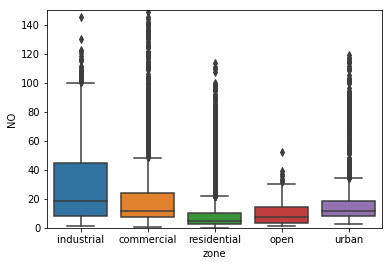

In [211]:
sns.boxplot(GSV_all['zone'], GSV_all['NO'])
plt.ylim([0,150]);

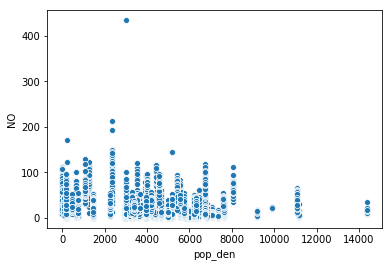

In [213]:
sns.scatterplot(GSV_all['pop_den'], GSV_all['NO']);

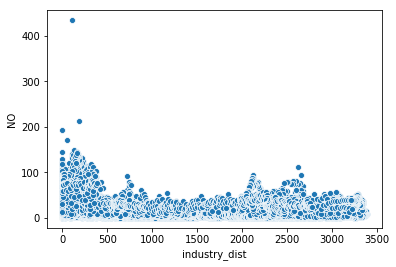

In [270]:
sns.scatterplot(GSV_all['industry_dist'], GSV_all['NO']);

In [278]:
GSV_all.to_csv('GSV_zoning_dist.csv')

In [15]:
oak_zones.head()

,zone,geometry,perimeter
0,commercial,(POLYGON ((-122.2196713301025 37.7705045999072...,7.197744e+05
1,industrial,(POLYGON ((-122.2790800006991 37.7962508110229...,8.390133e+05
2,open,(POLYGON ((-122.2009102096955 37.8242407727579...,6.484703e+05
3,residential,(POLYGON ((-122.176661736271 37.73183710086747...,3.745730e+06
4,urban,POLYGON ((-122.2638499119585 37.79715806503902...,1.784156e+05


In [16]:
out = oak_zones.drop(['perimeter'], axis=1)

In [18]:
out.to_csv('oakland_zoning.csv')

In [24]:
CA_tracts.to_csv('census_tracts.csv')

In [26]:
CA_tracts.head()

,population,pop_var,tract_name,GEOID,state,county,tract,geometry,area,pop_den
0,3353,332,"Census Tract 4001, Alameda County, California",6001400100,6,1,400100,"POLYGON ((-122.24692 37.885438, -122.246668 37...",6.889596,486.675821
1,1944,147,"Census Tract 4002, Alameda County, California",6001400200,6,1,400200,"POLYGON ((-122.257923 37.842606, -122.257728 3...",0.587043,3311.510730
2,5376,539,"Census Tract 4003, Alameda County, California",6001400300,6,1,400300,"POLYGON ((-122.265631 37.837636, -122.265565 3...",1.104561,4867.093849
3,4152,346,"Census Tract 4004, Alameda County, California",6001400400,6,1,400400,"POLYGON ((-122.261826 37.841623, -122.261805 3...",0.714232,5813.237557
4,3618,422,"Census Tract 4005, Alameda County, California",6001400500,6,1,400500,"POLYGON ((-122.269507 37.848582, -122.26937 37...",0.589893,6133.311264
